In [1]:
import numpy as np
from math import pi
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import zfit

ztf = zfit.ztf
ztyping = zfit.util.ztyping
ztypes = zfit.settings.ztypes

/Users/davide/miniconda3/envs/zfit_env/lib/python3.6/site-packages/zfit/util/execution.py:57: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
zfit.run.check_numerics = False
zfit.settings.set_verbosity(10)

In [4]:
def beta_l(q2, m):
    beta_l = ztf.sqrt(1-4*(ztf.square(m)/q2))
    return beta_l

def lambda_phase(m1, m2, q2):
    
    lambd = ztf.square(ztf.square(m1)-ztf.square(m2)) -2*q2*(ztf.square(m1)+ztf.square(m2)) + ztf.square(q2)
    
    return lambd

def beta_l_np(q2, m):
    beta_l = np.sqrt(1-4*(np.square(m)/q2))
    return beta_l

def lambda_phase_np(m1, m2, q2):
    
    lambd = np.square(np.square(m1)-np.square(m2)) -2*q2*(np.square(m1)+np.square(m2)) + np.square(q2)
    
    return lambd
def scalar_product_3_np(v1,v2):
    
    output = v1[:,1]*v2[:,1]+v1[:,2]*v2[:,2]+v1[:,3]*v2[:,3]
    return output

def scalar_product_4_np(v1,v2):
    
    scalar_3 = scalar_product_3_np(v1,v2)
    output = v1[:,0]*v2[:,0]- scalar_3
    return output


def a(q2, m, m1, m2):
    
    step1=q2*(1+ztf.square(beta_l(q2, m)))+ lambda_phase(m1, m2, q2)/2 + 2*m*(ztf.square(m1)-ztf.square(m2)+q2)+4*ztf.square(m)*ztf.square(m1)
    #step2 = beta_l(q2, m)*ztf.sqrt(lambda_phase(m1, m2, q2))*step1
    
    return step1

def b(q2, m, m1, m2):
    
    step1=2*(q2*(1+ztf.square(beta_l(q2, m)))+ m*(ztf.sqrt(lambda_phase(m1, m2, q2))*beta_l(q2,m)+(ztf.square(m1)-ztf.square(m2)+q2)))
    #step2 = beta_l(q2, m)*ztf.sqrt(lambda_phase(m1, m2, q2))*step1
    
    return step1

def c(q2, m, m1, m2):
    
    step1= q2*(1+ztf.square(beta_l(q2, m)))- lambda_phase(m1, m2, q2)/2 + 2*m*ztf.sqrt(lambda_phase(m1, m2, q2))*beta_l(q2, m)
    #step2 = beta_l(q2, m)*ztf.sqrt(lambda_phase(m1, m2, q2))*step1
    
    return step1


def matrix_elt(q2, m, m1, m2, cos_theta_l):
    
    out = a(q2, m, m1, m2)+b(q2, m, m1, m2)*cos_theta_l+c(q2, m, m1, m2)*ztf.square(cos_theta_l)
    
    return out               
                      
def phase_space(q2, m, m1, m2):
    
    phase_space_term = beta_l(q2, m)*ztf.sqrt(lambda_phase(m1, m2, q2))
    
    return phase_space_term
    

In [5]:
mmu_mass = 0.105
mB_mass=5.280
mKst_mass=0.892

lower_q2= 4*mmu_mass*mmu_mass
upper_q2=(mB_mass-mKst_mass)*(mB_mass-mKst_mass)
cutoff=0.01

In [6]:
class dGamma(zfit.pdf.ZPDF):
    
    _PARAMS = ['mB','mKst','ml']
    _N_OBS = 2
    VALID_LIMITS={
                  'cos_theta_l':(-1,1),
                  'q2': (lower_q2, upper_q2),
                  #'Eg': (cutoff, 10)
                 }
    
    def _unnormalized_pdf(self, x):
        
        ml = self.params['ml']
        mB = self.params['mB']
        mKst = self.params['mKst']
        
        q2, cos_theta_l = x.unstack_x()
        pdf = matrix_elt(q2, ml, mB, mKst, cos_theta_l)*phase_space(q2, ml, mB, mKst)
        #pdf= phase_space(q2, mB, mKst, ml)
        
        return pdf


In [7]:
mlepton_par = zfit.Parameter('ml', mmu_mass)
mB_par = zfit.Parameter('mB', mB_mass)
mKst_par = zfit.Parameter('mKst', mKst_mass)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
lower = ((lower_q2,  -1.),)
upper = ((upper_q2,   1.),)

obs = zfit.Space(["q2","cos_theta_l"], limits=(lower,upper))


In [9]:
pdf = dGamma(obs=obs, ml = mlepton_par, mB = mB_par, mKst = mKst_par)

In [10]:
n_events=100000

In [11]:
sampler = pdf.create_sampler(n=n_events)

Instructions for updating:
Use tf.cast instead.


In [12]:
for i in range(1):
    sampler.resample()


In [13]:
a=sampler.to_pandas()

In [14]:
q2vals_MC = np.array([a['q2'][i] for i in range(n_events)])
q2vals = q2vals_MC.reshape(n_events,1)

cos_theta_vals_MC = np.array([a['cos_theta_l'][i] for i in range(n_events)])
cos_theta_vals = cos_theta_vals_MC.reshape(n_events,1)

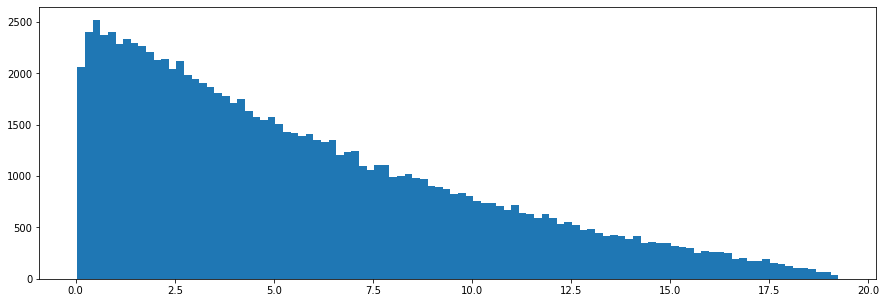

In [15]:
plt.hist(q2vals,bins=100);
fig = plt.gcf()
fig.set_size_inches(15,5)

In [16]:
def momenta_map(q2_, cos_theta_l_, m_l):
    n_events = q2_.shape[0]
    
    q2 = q2_.reshape(n_events,1)
    cos_theta_l = cos_theta_l_.reshape(n_events,1)

    kin_f = (np.square(mB_mass)+np.square(mKst_mass)-q2)/(2*mB_mass)

    sin_theta_l = np.sqrt(1-np.square(cos_theta_l))
    
    lambd = lambda_phase_np(mB_mass,mKst_mass,q2)
    
    beta = beta_l_np(q2, m_l) 
    
    phi_l = np.random.uniform(low=-pi,high=pi, size=(n_events,1))
    phi_Kst = np.random.uniform(low=-pi,high=pi, size=(n_events,1))
    theta_Kst = np.random.uniform(low=-pi,high=pi, size=(n_events,1))
    
    cos_phi_l = np.cos(phi_l)
    sin_phi_l = np.sin(phi_l)
    
    cos_phi_Kst = np.cos(phi_Kst)
    sin_phi_Kst = np.sin(phi_Kst)
    
    cos_theta_Kst = np.cos(theta_Kst)
    sin_theta_Kst = np.sin(theta_Kst)

    p1_B_0 = 0.5*(mB_mass-kin_f) - (beta*np.sqrt(lambd)*cos_theta_l)/(4*mB_mass)
    p1_B_1 = 0.5*beta*np.sqrt(q2)*sin_theta_l*cos_phi_l
    p1_B_2 = 0.5*beta*np.sqrt(q2)*sin_theta_l*sin_phi_l
    p1_B_3 = -np.sqrt(lambd)/(4*mB_mass) + 0.5*(mB_mass-kin_f)*beta*cos_theta_l

    p2_B_0 = 0.5*(mB_mass-kin_f) + (beta*np.sqrt(lambd)*cos_theta_l)/(4*mB_mass)
    p2_B_1 = -0.5*beta*np.sqrt(q2)*sin_theta_l*cos_phi_l
    p2_B_2 = -0.5*beta*np.sqrt(q2)*sin_theta_l*sin_phi_l
    p2_B_3 = -np.sqrt(lambd)/(4*mB_mass) - 0.5*(mB_mass-kin_f)*beta*cos_theta_l
    
    pKst_B_0 = kin_f
    pKst_B_1 = (np.sqrt(lambd)/(2*mB_mass))*(sin_theta_Kst*cos_phi_Kst)
    pKst_B_2 = (np.sqrt(lambd)/(2*mB_mass))*(sin_theta_Kst*sin_phi_Kst)
    pKst_B_3 = (np.sqrt(lambd)/(2*mB_mass))*cos_theta_Kst

    
    pKst_B = np.concatenate([pKst_B_0,
                             pKst_B_1,
                             pKst_B_2,
                             pKst_B_3], axis =1)
    
    p1_B = np.concatenate([p1_B_0,
                           p1_B_1,
                           p1_B_2,
                           p1_B_3], axis =1)
    
    p2_B = np.concatenate([p2_B_0,
                           p2_B_1,
                           p2_B_2,
                           p2_B_3], axis =1)
    
    return  pKst_B, p1_B, p2_B

In [17]:
pKst_B, p1_B, p2_B = momenta_map(q2vals_MC, cos_theta_vals_MC, mmu_mass)

In [18]:
scalar_product_4_np(p2_B,p2_B),scalar_product_4_np(pKst_B,pKst_B)

(array([0.011025, 0.011025, 0.011025, ..., 0.011025, 0.011025, 0.011025]),
 array([0.795664, 0.795664, 0.795664, ..., 0.795664, 0.795664, 0.795664]))

In [19]:
(pKst_B+p1_B+p2_B)[:,0].mean(), (pKst_B+p1_B+p2_B)[:,1].mean()


(5.280000000000001, -0.00010350998435309136)

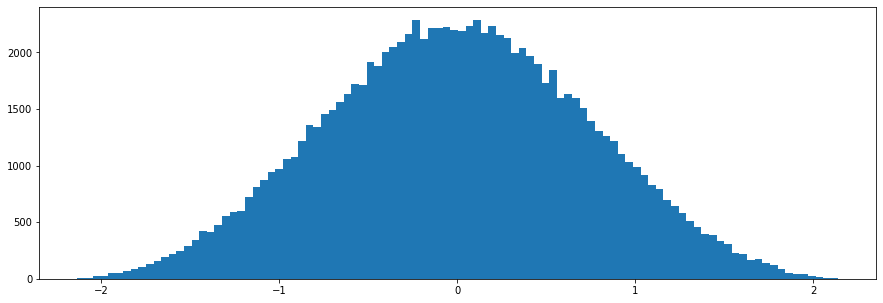

In [20]:
plt.hist(p1_B[:,2],bins=100);
fig = plt.gcf()
fig.set_size_inches(15,5)

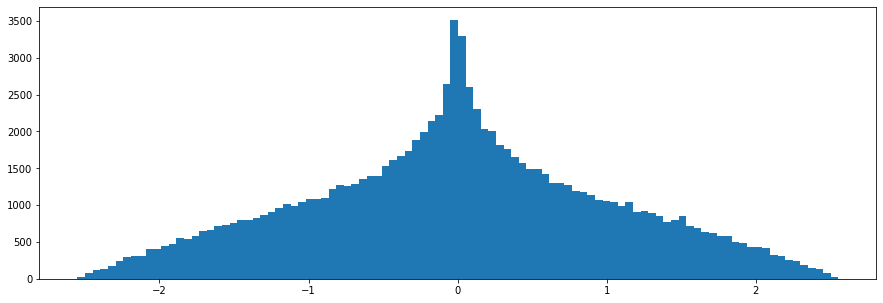

In [21]:
plt.hist(pKst_B[:,2],bins=100);
fig = plt.gcf()
fig.set_size_inches(15,5)